In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wandb
import random

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from wandb.keras import WandbCallback

Referencing: https://arxiv.org/pdf/2212.11285.pdf

We start off by loading in 1,000,000 background dijet events and 100,000 signal dijet events. The signal comes from the process Z$\rightarrow$ X($\rightarrow$ $q\bar{q}$) Y$\rightarrow$($q\bar{q}$) where Z is 3.5 TeV. X is 500 GeV and Y is 100 GeV. 

In [3]:
df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")

In [4]:
df_QCD

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1467.239990,611.502014,511.101990,38.896000,8.290650,4.836080,4.260190,1403.579956,-674.551025,-451.670990,237.893997,79.815102,21.010300,16.757601
1,-1211.239990,347.315002,547.963013,389.532013,191.804001,99.562798,70.872200,619.341003,-62.177299,-1944.040039,22.999201,8.042180,6.335090,5.525370
2,-1229.619995,649.857971,8.089170,72.155502,47.168098,37.243198,33.658199,1196.250000,-647.896973,-1283.109985,78.230698,15.292900,13.944200,10.013500
3,-693.304016,-1046.729980,1716.910034,55.797798,24.788500,6.890140,5.813400,747.961975,994.250000,-412.966003,359.113007,175.209000,103.500999,84.447098
4,-1488.199951,-25.370100,-30.989700,84.891502,26.878799,15.517200,13.260400,1415.640015,20.905100,223.630997,77.506500,57.986000,34.147400,26.660601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,-646.442017,-1295.150024,1331.800049,37.011299,21.006800,12.873700,8.898860,274.566986,1019.390015,-504.290985,90.375000,61.218800,20.514500,15.854600
999995,-286.550995,-1310.829956,-1510.910034,147.516998,60.997799,41.356201,28.225700,252.884995,1085.420044,759.314026,58.769901,42.276402,8.637120,7.852020
999996,918.562988,951.195984,-1622.569946,32.242199,5.894110,5.004100,3.992740,-266.285004,-1284.189941,185.007996,136.389008,70.623901,49.508499,40.708599
999997,1447.219971,-547.710999,827.945007,396.112000,181.406998,152.207993,86.676804,-932.369995,165.005005,-2806.959961,56.471600,14.446400,10.258900,8.874700


In [5]:
df = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")

In [6]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1698.670044,-884.039978,723.843018,105.035004,83.721703,46.282101,13.635700,1539.439941,372.238007,-295.865997,461.574005,431.343994,52.344799,37.284901
1,1246.660034,-1133.010010,-921.987000,159.865997,133.781998,58.968601,30.377399,-1218.489990,1108.380005,182.147003,514.883972,462.654999,138.789001,67.805801
2,420.975006,-1739.790039,281.553986,93.665901,77.925797,10.605900,6.916520,-510.779999,1484.069946,227.175995,475.316986,217.113998,29.424000,21.020300
3,161.048996,-1664.859985,-2005.099976,116.327003,61.819698,38.143600,18.414400,-188.942993,1556.900024,-561.664001,561.236023,348.181000,102.625000,53.422699
4,-564.754028,-1315.599976,-1087.410034,513.015991,276.446991,50.629799,35.460999,326.164001,1050.239990,1201.000000,108.752998,89.666603,40.928699,17.055799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,-206.662003,-1729.280029,357.635010,96.165001,58.014500,11.731300,6.174070,218.800003,1714.890015,-210.578995,472.475006,259.884003,40.806999,31.226000
99995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.890999,21.177200,10.582400,9.138590
99996,-1286.619995,-86.162598,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502
99997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726601,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301


Text(0.5, 1.0, 'Jet Mass Distributions')

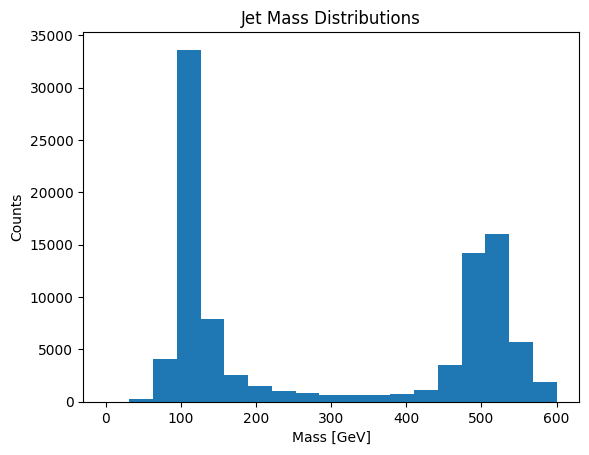

In [7]:
plt.hist(df['mj1'],bins=np.linspace(0,600,20))
plt.xlabel("Mass [GeV]")
plt.ylabel("Counts")
plt.title("Jet Mass Distributions")

In [10]:
file = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq.txt")

jets = []
count = 0
for line in file:
    if count == 2:
        break
    print(line)
    jets += [line.split("J")[1].split("P")[0].split()]
    count+=1

0 0 J 1788.55 -0.300279 -2.51608 130.279 0 0.0289343 0.0153102 0.0126833 0.010346 0.00825964  P 4.64413 -0.377384 3.00207  P 2.47947 -0.425799 3.02334  P 2.68613 -0.39458 -2.608  P 5.84707 -0.404504 -2.54133  P 24.9416 -0.408844 -2.52053  P 6.58412 -0.387347 -2.54543  P 13.1517 -0.350432 -2.59254  P 13.7381 -0.300859 -2.52212  P 4.55674 -0.286343 -2.52545  P 517.142 -0.286492 -2.50205 

0 1 J 1643.32 -0.173344 0.717105 95.8961 0 0.0424313 0.0221081 0.0140335 0.0108518 0.00877299  P 1.75001 -0.530883 0.585762  P 2.74298 -0.297844 0.694373  P 5.4756 -0.195946 0.630677  P 7.35714 -0.200437 0.647468  P 9.16487 -0.119969 0.704896  P 5.77878 -0.125155 0.709119  P 6.37682 -0.141306 0.773328  P 8.23397 -0.155549 0.732862  P 29.6409 -0.186092 0.763671  P 2.24246 -0.170876 0.729569  P 245.519 -0.180535 0.735561 



In [56]:
jets

[['1788.55',
  '-0.300279',
  '-2.51608',
  '130.279',
  '0',
  '0.0289343',
  '0.0153102',
  '0.0126833',
  '0.010346',
  '0.00825964'],
 ['1643.32',
  '-0.173344',
  '0.717105',
  '95.8961',
  '0',
  '0.0424313',
  '0.0221081',
  '0.0140335',
  '0.0108518',
  '0.00877299']]

In [31]:
ljet = [jets[2*n] for n in range(int(len(jets)/2))]
sjet = [jets[2*n+1] for n in range(int(len(jets)/2))]

In [32]:
ljet

[['1788.55',
  '-0.300279',
  '-2.51608',
  '130.279',
  '0',
  '0.0289343',
  '0.0153102',
  '0.0126833',
  '0.010346',
  '0.00825964']]

In [11]:
def computemjj_pd(event):
    px1 = event[["pxj1"]].to_numpy()
    py1 = event[["pyj1"]].to_numpy()
    pz1 = event[["pzj1"]].to_numpy()
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+event[["mj1"]].to_numpy()**2)
    
    px2 = event[["pxj2"]].to_numpy()
    py2 = event[["pyj2"]].to_numpy()
    pz2 = event[["pzj2"]].to_numpy()
    pE2 = np.sqrt(px1**2+py1**2+pz1**2+event[["mj2"]].to_numpy()**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [12]:
def computemjj_txt(event):
    pT1 = np.array([float(event[2*i][0]) for i in range(int(len(event)/2))])
    eta1 = np.array([float(event[2*i][1]) for i in range(int(len(event)/2))])
    phi1 = np.array([float(event[2*i][2]) for i in range(int(len(event)/2))])
    m1 = np.array([float(event[2*i][3]) for i in range(int(len(event)/2))])
    px1 = pT1*np.cos(phi1)
    py1 = pT1*np.sin(phi1)
    pz1 = pT1*np.sinh(eta1)
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+m1**2)
    
    pT2 = np.array([float(event[2*i+1][0]) for i in range(int(len(event)/2))])
    eta2 = np.array([float(event[2*i+1][1]) for i in range(int(len(event)/2))])
    phi2 = np.array([float(event[2*i+1][2]) for i in range(int(len(event)/2))])
    m2 = np.array([float(event[2*i+1][3]) for i in range(int(len(event)/2))])
    px2 = pT2*np.cos(phi2)
    py2 = pT2*np.sin(phi2)
    pz2 = pT2*np.sinh(eta2)
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+m2**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [13]:
m = 100
file = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(m)+"_"+str(m)+".txt")
jets_m_m = []
for line in file:
    jets_m_m+=[line.split("J")[1].split("P")[0].split()]
    pass
computemjj_txt(jets_m_m)[0]

3674.182176987098

In [44]:
len(jets_m_m)

180286

In [14]:
if (False):
    lmass_vec = {}
    x = {}
    mjjs = {}

    mu_m = 0.
    mu_t = 0.
    sd_m = 0.
    sd_t = 0.

    for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:

            print("on ...",m1,m2)

            ltau1_m_m = []
            ltau2_m_m = []
            stau1_m_m = []
            stau2_m_m = []
            if (m1>0 and m2>0):
                myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                jets_m_m = []
                for line in myfile:
                    jets_m_m+=[line.split("J")[1].split("P")[0].split()]
                    pass
                ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
                sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

                lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
                smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.

                ltau1_m_m = np.array([float(ljet_m_m[i][5]) for i in range(len(ljet_m_m))])
                ltau2_m_m = np.array([float(ljet_m_m[i][6]) for i in range(len(ljet_m_m))])

                stau1_m_m = np.array([float(sjet_m_m[i][5]) for i in range(len(ljet_m_m))])
                stau2_m_m = np.array([float(sjet_m_m[i][6]) for i in range(len(ljet_m_m))])

                mjj = computemjj_txt(jets_m_m)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]
                pass
            elif m1==0 and m2==0:
                df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
                lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
                smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.
                ltau1_m_m = np.array(df_QCD[["tau1j1"]]).flatten()
                ltau2_m_m = np.array(df_QCD[["tau2j1"]]).flatten()
                stau1_m_m = np.array(df_QCD[["tau1j2"]]).flatten()
                stau2_m_m = np.array(df_QCD[["tau2j2"]]).flatten()
                mjj = computemjj_pd(df_QCD)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]

                mu_m = np.mean(lmass_m_m)
                mu_t = np.mean(ltau2_m_m/(ltau1_m_m+0.0001))
                sd_m = np.std(lmass_m_m)
                sd_t = np.std(ltau2_m_m/(ltau1_m_m+0.0001))
                pass
            else:
                continue

            ms = np.stack([lmass_m_m,smass_m_m],axis=1)
            ts = np.stack([ltau2_m_m/(ltau1_m_m+0.0001),stau2_m_m/(stau1_m_m+0.001)],axis=1)
            order1 = [np.argmax(ms[i]) for i in range(len(ms))]
            order2 = [np.argmin(ms[i]) for i in range(len(ms))]
            mJ1 = np.array([ms[i][order1[i]] for i in range(len(ms))])
            mJ2 = np.array([ms[i][order2[i]] for i in range(len(ms))])
            x[m1,m2] = np.stack([(mJ2 - mu_m)/sd_m,
                                    ((mJ1 - mJ2) - mu_m)/sd_m,
                                    ([ts[i][order2[i]] for i in range(len(ts))] - mu_t)/sd_t,
                                    ([ts[i][order1[i]] for i in range(len(ts))] - mu_t)/sd_t],axis=1)
            lmass_vec[m1,m2]=lmass_m_m
            pass
        pass

    x_array = []
    for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            if (m1==0 and m2>0 or m2==0 and m1>0):
                continue
            x_array+=[x[m1,m2]]
    np.save("x_array", x_array)

In [53]:
#reads in data 
x = {}
x_array_read = np.load("x_array.npy",allow_pickle=True)
mycounter = -1
for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
    for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        mycounter+=1
        x[m1,m2] = x_array_read[mycounter]

In [42]:
x[3, 3]

array([[ 0.44009606, -0.82204661, -0.44848105, -0.81497215],
       [-0.14699141, -0.71452328, -1.76658658, -0.84676715],
       [ 0.33381894, -1.19508556, -1.79625529, -1.45038659],
       ...,
       [ 0.55389774, -1.28063173, -1.29173919, -2.02579372],
       [ 0.38147059, -1.30462293, -0.7246346 , -1.49577604],
       [ 0.10035066, -1.03229741, -1.30876893, -0.1639019 ]])

In [18]:
np.shape(x[5.5,5.5])

(60725, 4)

In [96]:
x[1,1]

array([[-0.72332359, -0.98361217, -1.47351623,  0.1065722 ],
       [-0.76381805, -1.17060296, -0.32160171, -1.15966026],
       [-0.53039583, -0.75444364, -0.83465484,  0.14455233],
       ...,
       [-0.72849452, -1.20127827, -1.46586875, -0.17525045],
       [-0.71564546, -1.27923195, -1.13014702,  0.1427768 ],
       [-0.69956274, -1.30933612, -0.96529716, -0.55303517]])

In [54]:
x_vals_100 = np.concatenate([x[1,1],x[0,0]])
y_vals_100 = np.concatenate([np.ones(len(x[1,1])),np.zeros(len(x[0,0]))])
X_train_100, X_val_100, Y_train_100, Y_val_100 = train_test_split(x_vals_100, y_vals_100, test_size=0.5)

In [55]:
x_vals_100

array([[-0.72332359, -0.98361217, -1.47351623,  0.1065722 ],
       [-0.76381805, -1.17060296, -0.32160171, -1.15966026],
       [-0.53039583, -0.75444364, -0.83465484,  0.14455233],
       ...,
       [-0.8137767 , -0.68498134, -0.48486568, -1.80944097],
       [-0.60554108, -0.3927861 ,  1.66516101, -0.46855806],
       [-1.03992653,  0.32502271,  1.51100575, -1.56040698]])

In [19]:
# model_100 = Sequential()
# model_100.add(Dense(128, input_dim=4, activation='relu'))
# model_100.add(Dense(128, activation='relu'))
# model_100.add(Dense(128, activation='relu'))
# model_100.add(Dense(1, activation='sigmoid'))
# model_100.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [69]:
#initializies wandb config
wandb.init(
    # set the wandb project where this run will be logged
    project="Anomaly",
    group="Dedicated",
    entity='gup-singh',

    config={
        "layer_1": 256,
        "activation_1": "relu",
        "layer_2": 256,
        "activation_2": "relu",
        "layer_3": 256,
        "activation_3": "relu",
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 20,
        "batch_size": 1024
    }
)

config = wandb.config

In [70]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        config = wandb.config
        self.dense1 = Dense(config.layer_1, activation=config.activation_1)
        
        self.dense2 = Dense(config.layer_2, activation=config.activation_2)
        
        self.dense3 = Dense(config.layer_3, activation=config.activation_3)
        
        self.dense4 = Dense(config.output_layer, activation=config.output_activation)
        
    def call(self, x):
        x = self.dense1(x)
        
        x = self.dense2(x)
        
        x = self.dense3(x)
        
        x = self.dense4(x)
        
        return x

In [71]:
model = MyModel()
model.build(input_shape=(None, X_train_100.shape[1]))
model.compile(loss=config.loss, optimizer=config.optimizer, metrics=["accuracy"])
model.summary()

Model: "my_model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            multiple                  1280      
                                                                 
 dense_45 (Dense)            multiple                  65792     
                                                                 
 dense_46 (Dense)            multiple                  65792     
                                                                 
 dense_47 (Dense)            multiple                  257       
                                                                 
Total params: 133,121
Trainable params: 133,121
Non-trainable params: 0
_________________________________________________________________


In [72]:
myhistory = model.fit(x_vals_100, y_vals_100, epochs=config.epoch, validation_data=(X_val_100, Y_val_100),batch_size=config.batch_size, callbacks=[WandbCallback()])

Epoch 1/20
170/193 [=========================>....] - ETA: 0s - loss: 0.2518 - accuracy: 0.8973

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230913_143526-opo3wb16/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230913_143526-opo3wb16/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.2452 - accuracy: 0.9002 - val_loss: 0.1919 - val_accuracy: 0.9237
Epoch 2/20
175/193 [==========================>...] - ETA: 0s - loss: 0.1821 - accuracy: 0.9268

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230913_143526-opo3wb16/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230913_143526-opo3wb16/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1820 - accuracy: 0.9268 - val_loss: 0.1805 - val_accuracy: 0.9277
Epoch 3/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1795 - accuracy: 0.9279 - val_loss: 0.1805 - val_accuracy: 0.9268
Epoch 4/20
178/193 [==========================>...] - ETA: 0s - loss: 0.1779 - accuracy: 0.9283

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230913_143526-opo3wb16/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230913_143526-opo3wb16/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1783 - accuracy: 0.9281 - val_loss: 0.1787 - val_accuracy: 0.9287
Epoch 5/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1779 - accuracy: 0.9283 - val_loss: 0.1802 - val_accuracy: 0.9282
Epoch 6/20
176/193 [==========================>...] - ETA: 0s - loss: 0.1776 - accuracy: 0.9283

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230913_143526-opo3wb16/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230913_143526-opo3wb16/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 7ms/step - loss: 0.1772 - accuracy: 0.9287 - val_loss: 0.1787 - val_accuracy: 0.9278
Epoch 7/20
182/193 [===========================>..] - ETA: 0s - loss: 0.1770 - accuracy: 0.9287

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230913_143526-opo3wb16/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230913_143526-opo3wb16/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1769 - accuracy: 0.9286 - val_loss: 0.1766 - val_accuracy: 0.9287
Epoch 8/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1763 - accuracy: 0.9286 - val_loss: 0.1797 - val_accuracy: 0.9276
Epoch 9/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1764 - accuracy: 0.9289 - val_loss: 0.1768 - val_accuracy: 0.9285
Epoch 10/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1761 - accuracy: 0.9290 - val_loss: 0.1775 - val_accuracy: 0.9285
Epoch 11/20
185/193 [===========================>..] - ETA: 0s - loss: 0.1764 - accuracy: 0.9289

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230913_143526-opo3wb16/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230913_143526-opo3wb16/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1764 - accuracy: 0.9289 - val_loss: 0.1761 - val_accuracy: 0.9289
Epoch 12/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1758 - accuracy: 0.9289 - val_loss: 0.1783 - val_accuracy: 0.9282
Epoch 13/20
181/193 [===========================>..] - ETA: 0s - loss: 0.1760 - accuracy: 0.9289

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230913_143526-opo3wb16/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230913_143526-opo3wb16/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1759 - accuracy: 0.9289 - val_loss: 0.1753 - val_accuracy: 0.9294
Epoch 14/20
175/193 [==========================>...] - ETA: 0s - loss: 0.1750 - accuracy: 0.9295

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230913_143526-opo3wb16/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230913_143526-opo3wb16/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1752 - accuracy: 0.9294 - val_loss: 0.1753 - val_accuracy: 0.9288
Epoch 15/20
182/193 [===========================>..] - ETA: 0s - loss: 0.1745 - accuracy: 0.9296

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230913_143526-opo3wb16/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230913_143526-opo3wb16/files/model-best)... Done. 0.0s


193/193 [==============================] - 1s 5ms/step - loss: 0.1745 - accuracy: 0.9296 - val_loss: 0.1751 - val_accuracy: 0.9289
Epoch 16/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1745 - accuracy: 0.9295 - val_loss: 0.1756 - val_accuracy: 0.9287
Epoch 17/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1747 - accuracy: 0.9293 - val_loss: 0.1762 - val_accuracy: 0.9286
Epoch 18/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1745 - accuracy: 0.9297 - val_loss: 0.1757 - val_accuracy: 0.9288
Epoch 19/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1742 - accuracy: 0.9295 - val_loss: 0.1758 - val_accuracy: 0.9288
Epoch 20/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1739 - accuracy: 0.9295 - val_loss: 0.1770 - val_accuracy: 0.9285


In [73]:
wandb.finish()

accuracy,▁▇██████████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▅▇▆▆▇▆▇▇▇▇█▇▇▇▇▇▇▇
val_loss,█▃▃▃▃▂▂▃▂▂▁▂▁▁▁▁▁▁▁▂
accuracy,0.92955
best_epoch,14
best_val_loss,0.17505
epoch,19
loss,0.17393
val_accuracy,0.92848


Analysis of Models begins here

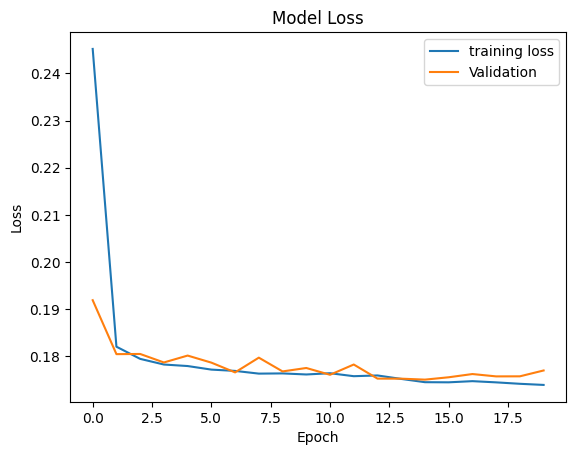

In [74]:
# Plot the training and validation loss
plt.plot(myhistory.history['loss'])
plt.plot(myhistory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'Validation'], loc='upper right')
plt.show()

In [75]:
preds_100 = model.predict(X_val_100,batch_size=1000)
fpr_100, tpr_100, _ = roc_curve(Y_val_100, preds_100)

99/99 [==============================] - 0s 649us/step


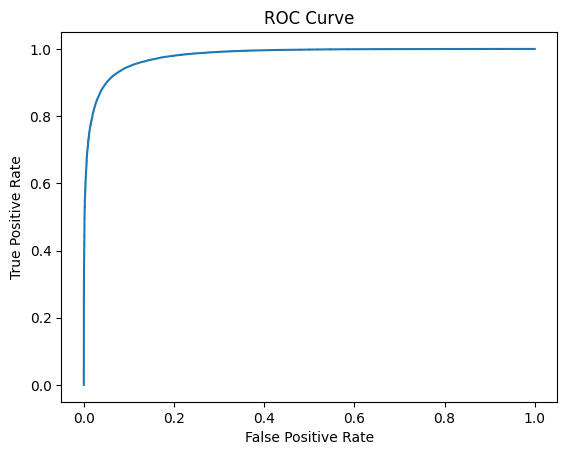

In [76]:
plt.plot(1-tpr_100, 1-fpr_100)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [77]:
def pred_accuracy(y_test, predictions):

    predictions_list = []
    for pred in predictions:
        #arbitrary cutoff of 0.5
        if float(pred) > 0.5:
            predictions_list.append(int(1))
        elif float(pred) < 0.5:
            predictions_list.append(int(0))
            
    accuracy = np.mean(predictions_list == y_test)
    return accuracy

accuracy_model = pred_accuracy(Y_val_100, list(preds_100))
print("Accuracy of Model: {:.2%}".format(accuracy_model))

Accuracy of Model: 92.85%


In [68]:
if (False):
    x_vals_all = []
    y_vals_all = []
    for m1 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0],m1*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1),m2*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2],m1*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_vals_all = np.concatenate([x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([np.ones(len(x_aug_0)),np.zeros(len(x_aug_m))])
            else:
                x_vals_all = np.concatenate([x_vals_all,x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([y_vals_all,np.ones(len(x_aug_0)),np.zeros(len(x_aug_m))])

    np.save("x_vals_all",x_vals_all)
    np.save("y_vals_all",y_vals_all)

0.5 0.5
0.5 1
0.5 1.5
0.5 2
0.5 2.5
0.5 3
0.5 3.5
0.5 4
0.5 4.5
0.5 5
0.5 5.5
0.5 6
1 0.5
1 1
1 1.5
1 2
1 2.5
1 3
1 3.5
1 4
1 4.5
1 5
1 5.5
1 6
1.5 0.5
1.5 1
1.5 1.5
1.5 2
1.5 2.5
1.5 3
1.5 3.5
1.5 4
1.5 4.5
1.5 5
1.5 5.5
1.5 6
2 0.5
2 1
2 1.5
2 2
2 2.5
2 3
2 3.5
2 4
2 4.5
2 5
2 5.5
2 6
2.5 0.5
2.5 1
2.5 1.5
2.5 2
2.5 2.5
2.5 3
2.5 3.5
2.5 4
2.5 4.5
2.5 5
2.5 5.5
2.5 6
3 0.5
3 1
3 1.5
3 2
3 2.5
3 3
3 3.5
3 4
3 4.5
3 5
3 5.5
3 6
3.5 0.5
3.5 1
3.5 1.5
3.5 2
3.5 2.5
3.5 3
3.5 3.5
3.5 4
3.5 4.5
3.5 5
3.5 5.5
3.5 6
4 0.5
4 1
4 1.5
4 2
4 2.5
4 3
4 3.5
4 4
4 4.5
4 5
4 5.5
4 6
4.5 0.5
4.5 1
4.5 1.5
4.5 2
4.5 2.5
4.5 3
4.5 3.5
4.5 4
4.5 4.5
4.5 5
4.5 5.5
4.5 6
5 0.5
5 1
5 1.5
5 2
5 2.5
5 3
5 3.5
5 4
5 4.5
5 5
5 5.5
5 6
5.5 0.5
5.5 1
5.5 1.5
5.5 2
5.5 2.5
5.5 3
5.5 3.5
5.5 4
5.5 4.5
5.5 5
5.5 5.5
5.5 6
6 0.5
6 1
6 1.5
6 2
6 2.5
6 3
6 3.5
6 4
6 4.5
6 5
6 5.5
6 6


In [97]:
x_aug_m

array([[-0.72413866,  1.69355063,  1.11205286, -1.87386705,  6.        ,
         6.        ],
       [ 0.80799657,  0.66064736, -0.59943671, -2.09319001,  6.        ,
         6.        ],
       [ 2.17499885, -1.1884174 , -1.60538663, -1.95211824,  6.        ,
         6.        ],
       ...,
       [ 2.25225265, -1.04538567, -1.74062478, -0.42062581,  6.        ,
         6.        ],
       [ 1.9191695 , -0.87384445, -1.59395235, -2.25172332,  6.        ,
         6.        ],
       [ 0.04826932,  1.34560735, -0.34342313, -1.79483175,  6.        ,
         6.        ]])

In [ ]:
#rewrite cell above to understand
x_valls_all = []
y_valls_all = []

mass_range = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
for m1 in mass_range:
    for m2 in mass_range:
        x_aug_0 = np.append(np.append())

In [66]:
test = np.append([[1, 2],[3, 4]], [[5, 6]], 0)
m1 = 0.5
m2 = 0.5
m1 = m1 * np.append(x[0,0],m1*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1)
m2 = m2 * np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1])
print(np.reshape(np.ones(len(x[0,0])),[len(x[0,0]), 1]))
print(m2)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[0.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]


In [18]:
x_vals_all = np.load("x_vals_all.npy")
y_vals_all = np.load("y_vals_all.npy")

In [19]:
X_train_all, X_val_all, Y_train_all, Y_val_all = train_test_split(x_vals_all, y_vals_all, test_size=0.5)

In [20]:
len(X_train_all)

13594326

In [40]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Anomaly",
    group="Parametrized",
    entity='gup-singh',

    config={
        "layer_1": 512,
        "activation_1": "relu",
        "layer_2": 512,
        "activation_2": "relu",
        "layer_3": 512,
        "activation_3": "relu",
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 20,
        "batch_size": 1024
    }
)

config = wandb.config

In [41]:
# model_all = Sequential()
# model_all.add(Dense(128, input_dim=6, activation='relu'))
# model_all.add(Dense(128, activation='relu'))
# model_all.add(Dense(128, activation='relu'))
# model_all.add(Dense(1, activation='sigmoid'))
# model_all.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_all = MyModel()
model_all.build(input_shape=(None, X_train_all.shape[1]))
model_all.compile(loss=config.loss, optimizer=config.optimizer, metrics=["accuracy"])
model_all.summary()

Model: "my_model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            multiple                  3584      
                                                                 
 dense_25 (Dense)            multiple                  262656    
                                                                 
 dense_26 (Dense)            multiple                  262656    
                                                                 
 dense_27 (Dense)            multiple                  513       
                                                                 
Total params: 529,409
Trainable params: 529,409
Non-trainable params: 0
_________________________________________________________________


In [42]:
myhistory_all = model_all.fit(x_vals_all, y_vals_all, epochs=config.epoch,validation_data=(X_val_all, Y_val_all),batch_size=config.batch_size*5, callbacks = [WandbCallback()])

Epoch 1/20
5306/5311 [============================>.] - ETA: 0s - loss: 0.1694 - accuracy: 0.9335

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230913_141923-357wcs2o/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230913_141923-357wcs2o/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 13s 2ms/step - loss: 0.1694 - accuracy: 0.9335 - val_loss: 0.1631 - val_accuracy: 0.9358
Epoch 2/20
5311/5311 [==============================] - ETA: 0s - loss: 0.1623 - accuracy: 0.9363

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230913_141923-357wcs2o/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230913_141923-357wcs2o/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 11s 2ms/step - loss: 0.1623 - accuracy: 0.9363 - val_loss: 0.1617 - val_accuracy: 0.9365
Epoch 3/20
5292/5311 [============================>.] - ETA: 0s - loss: 0.1616 - accuracy: 0.9366

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230913_141923-357wcs2o/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230913_141923-357wcs2o/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 11s 2ms/step - loss: 0.1616 - accuracy: 0.9366 - val_loss: 0.1609 - val_accuracy: 0.9368
Epoch 4/20
5311/5311 [==============================] - 11s 2ms/step - loss: 0.1613 - accuracy: 0.9367 - val_loss: 0.1611 - val_accuracy: 0.9369
Epoch 5/20
5286/5311 [============================>.] - ETA: 0s - loss: 0.1610 - accuracy: 0.9368

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230913_141923-357wcs2o/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230913_141923-357wcs2o/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 11s 2ms/step - loss: 0.1610 - accuracy: 0.9368 - val_loss: 0.1607 - val_accuracy: 0.9369
Epoch 6/20
5293/5311 [============================>.] - ETA: 0s - loss: 0.1608 - accuracy: 0.9369

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230913_141923-357wcs2o/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230913_141923-357wcs2o/files/model-best)... Done. 0.1s


5311/5311 [==============================] - 11s 2ms/step - loss: 0.1608 - accuracy: 0.9369 - val_loss: 0.1602 - val_accuracy: 0.9371
Epoch 7/20
5311/5311 [==============================] - 11s 2ms/step - loss: 0.1606 - accuracy: 0.9370 - val_loss: 0.1604 - val_accuracy: 0.9371
Epoch 8/20
5311/5311 [==============================] - 11s 2ms/step - loss: 0.1605 - accuracy: 0.9370 - val_loss: 0.1606 - val_accuracy: 0.9369
Epoch 9/20
5289/5311 [============================>.] - ETA: 0s - loss: 0.1604 - accuracy: 0.9371

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230913_141923-357wcs2o/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230913_141923-357wcs2o/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 11s 2ms/step - loss: 0.1604 - accuracy: 0.9371 - val_loss: 0.1600 - val_accuracy: 0.9373
Epoch 10/20
5311/5311 [==============================] - 11s 2ms/step - loss: 0.1602 - accuracy: 0.9371 - val_loss: 0.1605 - val_accuracy: 0.9369
Epoch 11/20
5311/5311 [==============================] - 11s 2ms/step - loss: 0.1602 - accuracy: 0.9371 - val_loss: 0.1601 - val_accuracy: 0.9372
Epoch 12/20
5291/5311 [============================>.] - ETA: 0s - loss: 0.1601 - accuracy: 0.9372

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230913_141923-357wcs2o/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230913_141923-357wcs2o/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 11s 2ms/step - loss: 0.1601 - accuracy: 0.9372 - val_loss: 0.1598 - val_accuracy: 0.9373
Epoch 13/20
5287/5311 [============================>.] - ETA: 0s - loss: 0.1599 - accuracy: 0.9372

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230913_141923-357wcs2o/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230913_141923-357wcs2o/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 11s 2ms/step - loss: 0.1600 - accuracy: 0.9372 - val_loss: 0.1595 - val_accuracy: 0.9374
Epoch 14/20
5311/5311 [==============================] - 11s 2ms/step - loss: 0.1599 - accuracy: 0.9373 - val_loss: 0.1596 - val_accuracy: 0.9373
Epoch 15/20
5311/5311 [==============================] - 11s 2ms/step - loss: 0.1598 - accuracy: 0.9372 - val_loss: 0.1598 - val_accuracy: 0.9372
Epoch 16/20
5311/5311 [==============================] - 11s 2ms/step - loss: 0.1597 - accuracy: 0.9373 - val_loss: 0.1596 - val_accuracy: 0.9373
Epoch 17/20
5308/5311 [============================>.] - ETA: 0s - loss: 0.1596 - accuracy: 0.9373

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230913_141923-357wcs2o/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230913_141923-357wcs2o/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 11s 2ms/step - loss: 0.1596 - accuracy: 0.9373 - val_loss: 0.1595 - val_accuracy: 0.9374
Epoch 18/20
5311/5311 [==============================] - 11s 2ms/step - loss: 0.1595 - accuracy: 0.9374 - val_loss: 0.1599 - val_accuracy: 0.9372
Epoch 19/20
5311/5311 [==============================] - 11s 2ms/step - loss: 0.1595 - accuracy: 0.9374 - val_loss: 0.1597 - val_accuracy: 0.9373
Epoch 20/20
5297/5311 [============================>.] - ETA: 0s - loss: 0.1594 - accuracy: 0.9374

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/SULI/wandb/run-20230913_141923-357wcs2o/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/SULI/wandb/run-20230913_141923-357wcs2o/files/model-best)... Done. 0.0s


5311/5311 [==============================] - 11s 2ms/step - loss: 0.1594 - accuracy: 0.9374 - val_loss: 0.1595 - val_accuracy: 0.9374


In [43]:
wandb.finish()

accuracy,▁▆▇▇▇▇▇▇▇▇▇█████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▆▇▆▇███▇██▇██
val_loss,█▅▄▄▃▂▃▃▂▃▂▂▁▁▂▁▁▂▁▁
accuracy,0.93738
best_epoch,19
best_val_loss,0.15948
epoch,19
loss,0.15938
val_accuracy,0.93736


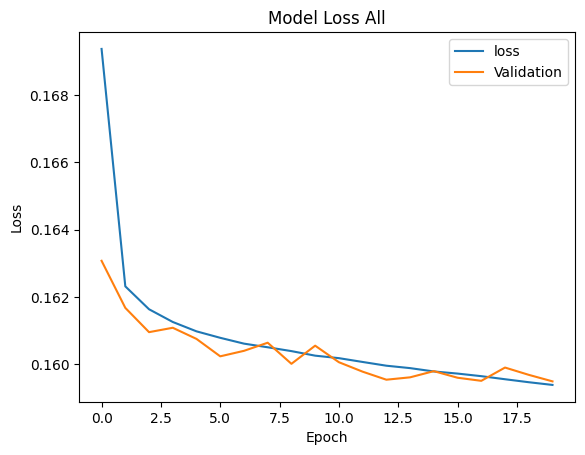

In [44]:
# Plot the training and validation loss
plt.plot(myhistory_all.history['loss'])
plt.plot(myhistory_all.history['val_loss'])
plt.title('Model Loss All')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'Validation'], loc='upper right')
plt.show()

In [45]:
preds_all = model_all.predict(X_val_all[np.product(X_val_all[:,4:6]==[1.,1.],axis=1)==1],batch_size=1000)

99/99 [==============================] - 0s 683us/step


In [46]:
fpr_all, tpr_all, _ = roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1.,1.],axis=1)==1], preds_all)

/tmp/ipykernel_74074/2844161687.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_100,1./fpr_100,label="dedicated_100")
/tmp/ipykernel_74074/2844161687.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_200,1./fpr_200,label="dedicated_200")
/tmp/ipykernel_74074/2844161687.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all,1./fpr_all,label="parameterized")


Text(0.5, 1.0, '$(m_B,m_C) = (100,100)$ GeV')

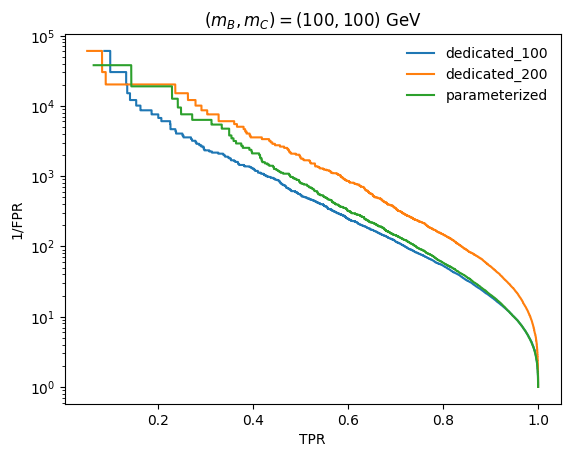

In [91]:
plt.plot(tpr_100,1./fpr_100,label="dedicated_100")
plt.plot(tpr_200,1./fpr_200,label="dedicated_200")
plt.plot(tpr_all,1./fpr_all,label="parameterized")
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_B,m_C) = (100,100)$ GeV")